In [1]:
reset -fs

In [2]:
import numpy as np
import nltk

import re
import string

import matplotlib.pyplot as plt
import seaborn as snsLatent

import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.shape

(23486, 10)

# Data Cleaning

In [5]:
df = df.drop(['Title', 'Clothing ID', 'Positive Feedback Count','Age', 'Recommended IND','Division Name'
            ,'Department Name', 'Class Name'], axis=1)
df.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


In [6]:
# data with rating below 4
df2 = df[df.Rating < 4]

In [7]:
df2.head()

,Review Text,Rating
2,I had such high hopes for this dress and reall...,3
5,"I love tracy reese dresses, but this one is no...",2
10,Dress runs small esp where the zipper area run...,3
14,This is a nice choice for holiday gatherings. ...,3
16,Material and color is nice. the leg opening i...,3


In [8]:
df2.shape

(5278, 2)

In [9]:
# Check missing values
df2.isna().sum()

Review Text    85
Rating          0
dtype: int64

In [10]:
# Drop missing values for 'review text'
df2 = df2.dropna(subset=['Review Text', 'Rating'], axis=0)
df2 = df2.reset_index(drop=True)

In [11]:
df2.shape

(5193, 2)

In [12]:
df2['text_length'] = df2['Review Text'].apply(lambda x: len(x.strip().split()))

In [13]:
df2.text_length.describe()

count    5193.000000
mean       62.690545
std        27.301185
min         3.000000
25%        40.000000
50%        62.000000
75%        90.000000
max       115.000000
Name: text_length, dtype: float64

In [14]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    text=re.sub(r'_', ' ', text)
    
    return text

In [15]:
df2['Review_Text'] = df2['Review Text'].apply(clean)
df2['Review_Text'].head()

0    i had such high hopes for this dress and reall...
1    i love tracy reese dresses  but this one is no...
2    dress runs small esp where the zipper area run...
3    this is a nice choice for holiday gatherings  ...
4    material and color is nice   the leg opening i...
Name: Review_Text, dtype: object

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/pramila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/pramila/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [19]:
def Lemmatization(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [20]:
df2['clean_text'] = df2['Review_Text'].apply(Lemmatization)
df2['clean_text'].head()

0    i had such high hope for this dress and really...
1    i love tracy reese dress but this one is not f...
2    dress run small esp where the zipper area run ...
3    this is a nice choice for holiday gathering i ...
4    material and color is nice the leg opening is ...
Name: clean_text, dtype: object

In [21]:
df2.head()

,Review Text,Rating,text_length,Review_Text,clean_text
0,I had such high hopes for this dress and reall...,3,98,i had such high hopes for this dress and reall...,i had such high hope for this dress and really...
1,"I love tracy reese dresses, but this one is no...",2,98,i love tracy reese dresses but this one is no...,i love tracy reese dress but this one is not f...
2,Dress runs small esp where the zipper area run...,3,66,dress runs small esp where the zipper area run...,dress run small esp where the zipper area run ...
3,This is a nice choice for holiday gatherings. ...,3,96,this is a nice choice for holiday gatherings ...,this is a nice choice for holiday gathering i ...
4,Material and color is nice. the leg opening i...,3,73,material and color is nice the leg opening i...,material and color is nice the leg opening is ...


In [22]:
print(np.max(df2.text_length))

115


#  Doc metric using Vectorization

In [23]:
#model function

def display_topics(docs, vectorizer, topic_modeler, print_n_words=15):
    
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    words_in_doc = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        top_words = [words_in_doc[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    print(topic_modeler.components_.shape)
    return doc_topic_vectors

# LSA with Tfidf

In [24]:
docs = df2['clean_text']
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
topic_modeler = TruncatedSVD(5, random_state=10)  
display_topics(docs, vectorizer, topic_modeler, print_n_words=15)

Topic 0:
 DRESS, LIKE, SIZE, LOOK, FIT, JUST, FABRIC, SMALL, LOVE, COLOR, REALLY, ORDERED, SHIRT, LARGE, MATERIAL 

Topic 1:
 DRESS, SLIP, BEAUTIFUL, ZIPPER, SACK, PERFECT, BUST, LINING, WEDDING, HIP, BELT, HEAVY, SAD, FABRIC, KNEE 

Topic 2:
 SIZE, SMALL, LARGE, RUN, ORDERED, MEDIUM, USUALLY, TIGHT, FIT, BIG, WEAR, SMALLER, NORMALLY, PETITE, RAN 

Topic 3:
 SHIRT, DRESS, CUTE, WEAR, WHITE, PRICE, HOLE, WASHED, WORTH, DRY, LOVED, SHEER, BOUGHT, CHEST, WASH 

Topic 4:
 LOOK, ARM, SHIRT, WORK, MODEL, LARGE, BIG, BOXY, DIDN, SLEEVE, BODY, SHOULDER, WIDE, CHEST, WAY 

(5, 3581)


/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[ 0.22685493,  0.02611013,  0.15251152, -0.01166424,  0.01491213],
       [ 0.27969504,  0.21386462,  0.01787429,  0.00562941, -0.0148408 ],
       [ 0.27161365,  0.12188783,  0.06334585,  0.03323274, -0.02504551],
       ...,
       [ 0.1683364 , -0.0456111 , -0.08849406, -0.04336829,  0.01494223],
       [ 0.17427204, -0.02602053, -0.01189575, -0.00299338, -0.09628154],
       [ 0.28334401,  0.12042557,  0.02079533,  0.0206513 , -0.0060306 ]])

# Remove Common Stop words

In [59]:
stop_words = list(text.ENGLISH_STOP_WORDS)
new_stop_words = ['love', 'flattering','loved', 'usually', 'didn', 'did', 'online','cute', 'nice',
                 'really','perfect','look','looks','good','white', 'like', 'disappointed', 'great',
                 'beautiful', 'dress', 'got', 'boxy', 'ordered', 'wanted','way']
all_stop_words = stop_words + new_stop_words

#for i in new_stop_words:
#    stop_words.append(i)

len(all_stop_words)

343

In [26]:
#print(all_stop_words)

# after adding custom stop words and tuned hyperparameter

In [27]:
# LSA with additional stop words 
docs = df2['clean_text']
#LSA with CountVectorizer

#vectorizer = CountVectorizer(stop_words=all_stop_words, max_df=0.5, min_df=1)

#LSA with TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words= all_stop_words, max_df=0.5, min_df=2)
topic_modeler = TruncatedSVD(5, random_state=10)  
display_topics(docs, vectorizer, topic_modeler, print_n_words=15)


Topic 0:
 SIZE, FIT, JUST, SMALL, FABRIC, COLOR, SHIRT, LARGE, WEAR, MATERIAL, WAY, SHORT, BIG, WORK, RUN 

Topic 1:
 SHIRT, FABRIC, SWEATER, COLOR, QUALITY, MATERIAL, PRICE, JUST, CHEAP, DESIGN, HA, SOFT, CUT, PICTURE, SHAPE 

Topic 2:
 SHIRT, SMALL, RUN, LARGE, SIZE, MEDIUM, WEAR, CHEST, NORMALLY, HOLE, SMALLER, ARM, ORDER, EXTREMELY, XL 

Topic 3:
 SWEATER, ARM, SLEEVE, SMALL, SHORT, LARGE, BIG, ITCHY, RUN, SHOULDER, LONG, MEDIUM, MODEL, LENGTH, SOFT 

Topic 4:
 SHORT, WORK, LENGTH, ARM, WAIST, LONG, FIT, PETITE, SHIRT, TIGHT, WIDE, SLEEVE, BODY, HIP, TORSO 

(5, 3558)


array([[ 0.21839273, -0.12232856,  0.02383436,  0.00252795,  0.01026074],
       [ 0.19849205, -0.00393401, -0.06038196, -0.04192049,  0.05286136],
       [ 0.22555637, -0.05337666,  0.00618832, -0.016756  , -0.11508127],
       ...,
       [ 0.17287077,  0.0847802 , -0.0614775 ,  0.01301485,  0.03327906],
       [ 0.15280749,  0.00913248, -0.02399859, -0.09159322, -0.00733297],
       [ 0.23145828, -0.01601595, -0.04186009, -0.02059025,  0.03689795]])

# Non-Negative Matrix Factorization (NMF) with CountVectorizer

In [28]:
docs = df2['clean_text']
vectorizer = CountVectorizer(stop_words=all_stop_words, max_df=0.5, min_df=2)
topic_modeler = NMF(5, random_state=10, max_iter=1000) 

display_topics(docs, vectorizer, topic_modeler)

Topic 0:
 JUST, COLOR, MATERIAL, SWEATER, LOOKED, WAY, WORK, SHORT, QUALITY, WEAR, BIG, CUT, MODEL, SLEEVE, TRIED 

Topic 1:
 SIZE, SMALL, LARGE, RUN, WEAR, MEDIUM, BIG, TRIED, WAY, PETITE, TIGHT, SMALLER, RETAILER, TRUE, WAIST 

Topic 2:
 FIT, ARM, WAIST, SMALL, TIGHT, LARGE, BUST, LOOSE, PETITE, MEDIUM, LONG, SHOULDER, MODEL, BETTER, CHEST 

Topic 3:
 SHIRT, WEAR, SMALL, ARM, MATERIAL, SHORT, HOLE, RETAILER, CHEST, MAKE, BOUGHT, SLEEVE, LARGE, WASH, THINK 

Topic 4:
 FABRIC, COLOR, WEAR, QUALITY, HA, DESIGN, FEEL, CHEAP, SKIRT, PRETTY, CUT, SOFT, WAIST, MAKE, WAY 

(5, 3558)


/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.09842327, 0.25519572, 0.15995009, 0.        , 0.        ],
       [0.2555557 , 0.03825382, 0.        , 0.        , 0.        ],
       [0.09704331, 0.05724706, 0.13146282, 0.        , 0.15966202],
       ...,
       [0.15442298, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.11828622, 0.        , 0.15599893],
       [0.1095931 , 0.00399863, 0.28144794, 0.        , 0.        ]])

# Non-Negative Matrix Factorization (NMF) with TfidfVectorizer

In [29]:
docs = df2['clean_text']
vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.5, min_df=2)
topic_modeler = NMF(5, random_state=10, max_iter=1000) 

display_topics(docs, vectorizer, topic_modeler)

/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 0:
 FABRIC, COLOR, MATERIAL, QUALITY, DESIGN, JUST, PRICE, WEAR, SKIRT, CHEAP, HA, FEEL, LOOKED, RETURNED, PANT 

Topic 1:
 SIZE, SMALL, LARGE, RUN, MEDIUM, WEAR, BIG, SMALLER, HUGE, FIT, NORMALLY, TIGHT, RAN, ORDER, RETAILER 

Topic 2:
 SHIRT, WEAR, HOLE, WASHED, SLEEVE, MATERIAL, SHRUNK, CHEST, BOUGHT, WORTH, RETURNING, WASH, DRY, SHORT, UNDERNEATH 

Topic 3:
 SWEATER, SLEEVE, ITCHY, COLOR, MODEL, SOFT, WOOL, LONG, PICTURE, LOOKING, ARM, SCRATCHY, LARGE, KNIT, WARM 

Topic 4:
 FIT, JUST, SHORT, WORK, WAY, WAIST, ARM, PETITE, LENGTH, LONG, MODEL, BODY, WIDE, SLEEVE, CUT 

(5, 3558)


/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.01297337, 0.07148021, 0.        , 0.        , 0.04402296],
       [0.03356083, 0.01977694, 0.        , 0.        , 0.05071098],
       [0.0462891 , 0.05697228, 0.        , 0.        , 0.01950646],
       ...,
       [0.02816846, 0.        , 0.00565189, 0.01079923, 0.05723245],
       [0.04491448, 0.01836091, 0.        , 0.        , 0.0106599 ],
       [0.0173607 , 0.02328537, 0.0022049 , 0.        , 0.08418852]])

# LDA 

In [30]:
from sklearn import datasets
from sklearn.decomposition import LatentDirichletAllocation

In [31]:
docs = df2['Review Text']

#vectorizer = CountVectorizer(stop_words=all_stop_words, max_df=0.5, min_df=2)


vectorizer = TfidfVectorizer(stop_words= all_stop_words, max_df=0.5, min_df=2)
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=42)  
display_topics(docs, vectorizer, lda_tfidf, print_n_words=15)

Topic 0:
 FIT, SIZE, JUST, FABRIC, SMALL, SHIRT, WEAR, COLOR, WAY, MATERIAL, QUALITY, TRIED, LARGE, SHORT, WAIST 

Topic 1:
 KIMONO, SWEET, PILLED, DRESSED, DESIGN, ROUGH, MUDDY, DROOPY, DISAPPOINTMENT, UNBUTTONED, UNRAVELED, LUMP, SASH, DARTS, SAUSAGE 

Topic 2:
 SIZE, SMALL, FIT, FABRIC, LARGE, JUST, MATERIAL, COLOR, BIG, SWEATER, SHIRT, REVIEWS, MEDIUM, SKIRT, RETURN 

Topic 3:
 SWEATER, SHAPE, MATERIAL, JUST, LOOKED, FABRIC, QUALITY, UNFLATTERING, MODEL, RETURNED, PICTURE, WAY, WORK, RETURNING, PRETTY 

Topic 4:
 SIZE, FIT, JUST, SMALL, XS, PETITE, FABRIC, SHIRT, SWEATER, COLOR, WEAR, WAY, GOING, LENGTH, LARGE 

(5, 4090)


array([[0.86948238, 0.03228232, 0.03302541, 0.03255275, 0.03265715],
       [0.72183343, 0.03336632, 0.03403557, 0.17600783, 0.03475685],
       [0.85440878, 0.03604366, 0.03649366, 0.03646708, 0.03658683],
       ...,
       [0.84143156, 0.03856838, 0.03945967, 0.04056521, 0.03997518],
       [0.79081006, 0.05154416, 0.05292292, 0.0520262 , 0.05269665],
       [0.50581783, 0.03417444, 0.38961305, 0.03577206, 0.03462262]])

### After adding costum stop-word list NMF and TfidfVectorizer had the better results and cleaner topics 

# Non-Negative Matrix Factorization (NMF) with Tfidf

In [73]:
vectorizer = TfidfVectorizer(stop_words= all_stop_words, max_df=0.5, min_df=2)
doc_word = vectorizer.fit_transform(df2['clean_text'].tolist())
doc_word.shape
doc_word = vectorizer.get_feature_names()
#pd.DataFrame(doc_word.toarray(), index=df2['clean_text'].tolist(), columns=vectorizer.get_feature_names()).head(10)

/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [72]:
nmf_model = NMF(4, random_state=10, max_iter=1000)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [74]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = vectorizer.get_feature_names())
topic_word

,abdomen,ability,able,absolute,absolutely,absurd,abundance,accent,accentuate,accentuated,...,yuck,yummy,yup,zag,zero,zig,zip,zipped,zipper,zoom
component_1,0.004,0.003,0.043,0.004,0.086,0.003,0.002,0.014,0.009,0.015,...,0.002,0.004,0.002,0.002,0.011,0.002,0.021,0.002,0.105,0.001
component_2,0.004,0.001,0.044,0.003,0.040,0.001,0.000,0.000,0.005,0.000,...,0.003,0.000,0.003,0.000,0.009,0.000,0.046,0.034,0.040,0.000
component_3,0.000,0.002,0.021,0.000,0.025,0.000,0.000,0.001,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006
component_4,0.004,0.000,0.000,0.000,0.000,0.000,0.006,0.009,0.003,0.003,...,0.000,0.000,0.000,0.008,0.000,0.008,0.000,0.000,0.000,0.000


### Display topics using NMF Tfidf Vectorizer

In [75]:
docs = df2['clean_text']
vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.5, min_df=2)
topic_modeler = NMF(4, random_state=10, max_iter=1000) 

doc_topic_vectors = display_topics(docs, vectorizer, topic_modeler)
doc_topic_vectors

Topic 0:
 JUST, FABRIC, COLOR, FIT, MATERIAL, LOOKED, QUALITY, WORK, SHORT, CUT, WAIST, PRETTY, DESIGN, SKIRT, SHAPE 

Topic 1:
 SIZE, SMALL, LARGE, RUN, MEDIUM, BIG, FIT, WEAR, TIGHT, SMALLER, ARM, HUGE, NORMALLY, CHEST, PETITE 

Topic 2:
 SHIRT, WEAR, MATERIAL, SHORT, WASHED, HOLE, SLEEVE, ARM, BOUGHT, WORTH, PRICE, WASH, SHRUNK, RETURNING, DRY 

Topic 3:
 SWEATER, SLEEVE, ARM, ITCHY, LONG, MODEL, COLOR, SHORT, SOFT, LENGTH, WOOL, PICTURE, LOOKING, DESIGN, SHOULDER 

(4, 3557)


/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/pramila/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.0286727 , 0.07756443, 0.        , 0.        ],
       [0.0555071 , 0.01916889, 0.        , 0.        ],
       [0.04473493, 0.0559793 , 0.        , 0.        ],
       ...,
       [0.05464886, 0.        , 0.00529391, 0.01294897],
       [0.04016744, 0.01851584, 0.        , 0.        ],
       [0.05147965, 0.03179354, 0.00289377, 0.00015826]])

In [76]:
df_topic = df2[['Rating','clean_text']]

In [77]:
df_topic['topic'] = doc_topic_vectors.argmax(axis=1)

/var/folders/dy/63r9w1v578v1x17vwmwhknwm0000gn/T/ipykernel_18008/2880897813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic['topic'] = doc_topic_vectors.argmax(axis=1)


In [82]:
# label each topics
topic_names = []
tmap = {
    0: 'Fabric quality',
    1: 'Fitting issues',
    2: 'Spoiled after wash',
    3: 'Issues with Woolens'
}
for t_id in doc_topic_vectors.argmax(axis=1):
    topic_names.append(tmap[t_id])
    
df_topic['topic_label'] = topic_names

/var/folders/dy/63r9w1v578v1x17vwmwhknwm0000gn/T/ipykernel_18008/3919810441.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic['topic_label'] = topic_names


In [83]:
df_topic

,Rating,clean_text,topic,topic_label
0,3,i had such high hope for this dress and really...,1,Fitting issues
1,2,i love tracy reese dress but this one is not f...,0,Fabric quality
2,3,dress run small esp where the zipper area run ...,1,Fitting issues
3,3,this is a nice choice for holiday gathering i ...,1,Fitting issues
4,3,material and color is nice the leg opening is ...,0,Fabric quality
...,...,...,...,...
5188,3,cute dress but not for me the waist is too hig...,0,Fabric quality
5189,1,i wa surprised at the positive review for this...,0,Fabric quality
5190,3,it reminds me of maternity clothes soft stretc...,0,Fabric quality
5191,3,this fit well but the top wa very see through ...,0,Fabric quality


In [84]:
df_topic.to_csv('ratingVStopics2.csv')

In [79]:
# plot top words in each topics
def top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

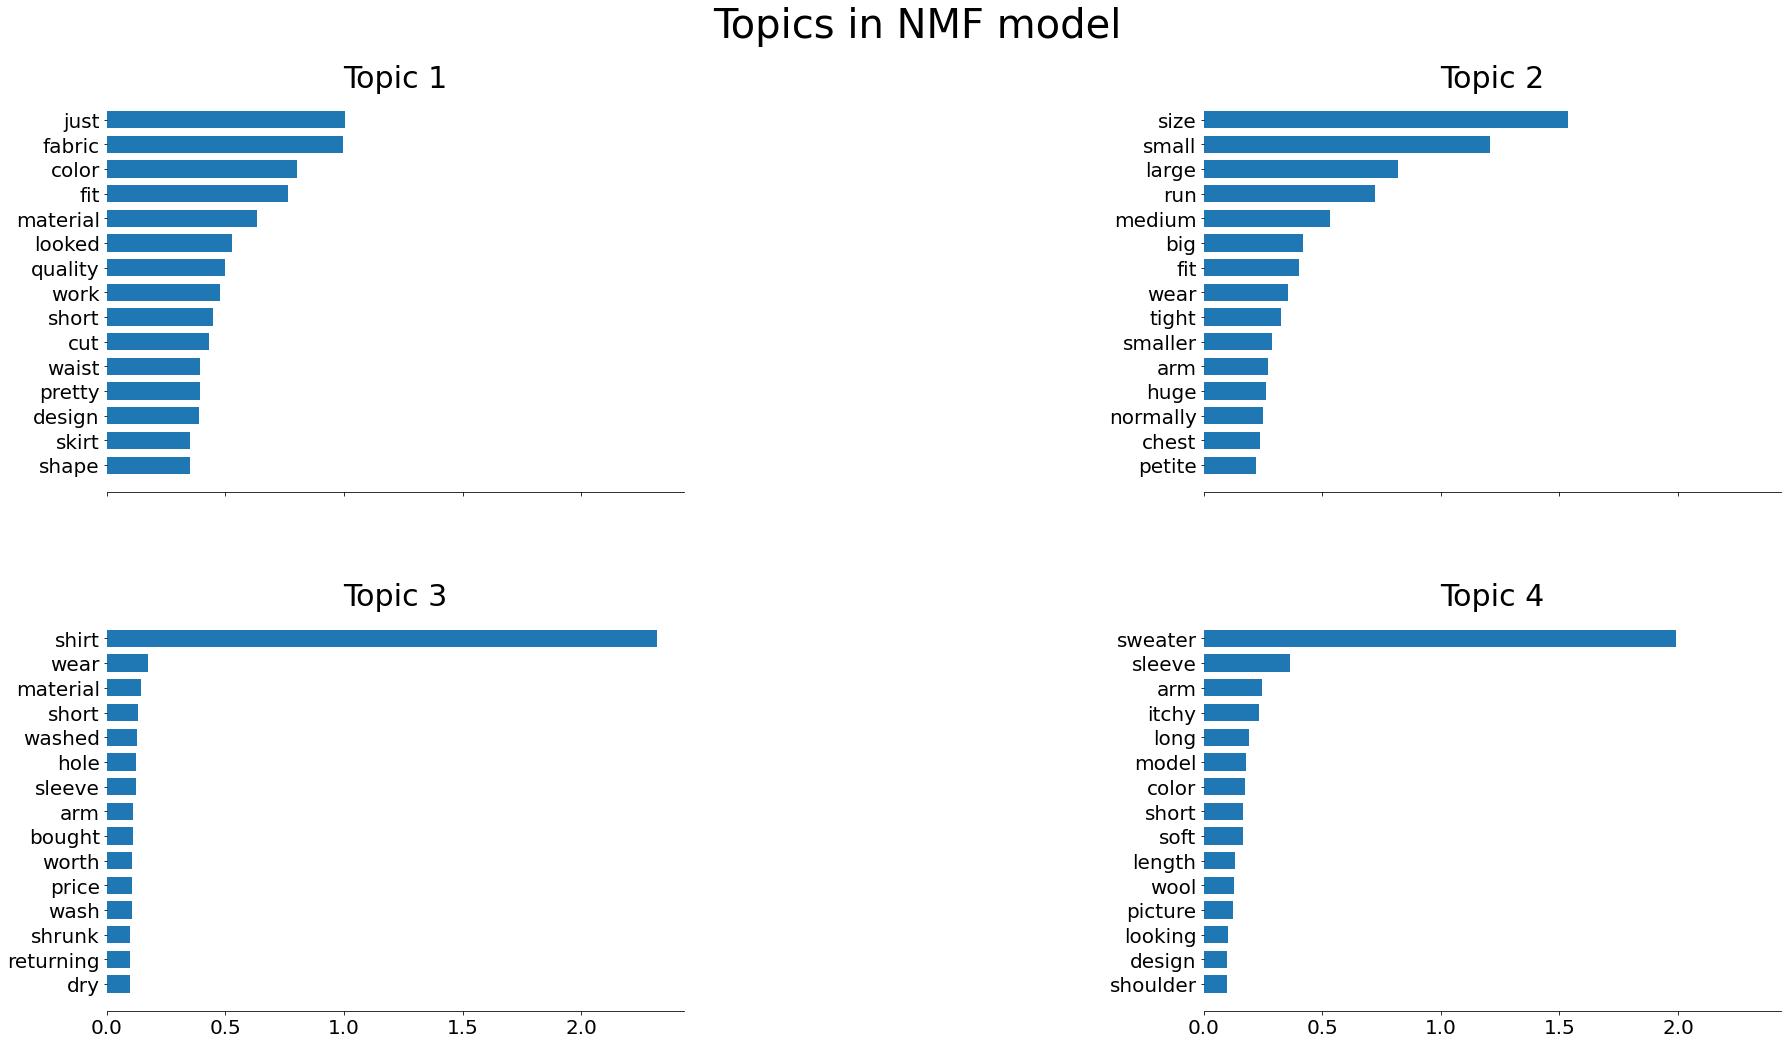

In [80]:
top_words(nmf_model, doc_word, 15, "Topics in NMF model")